<a href="https://colab.research.google.com/github/SESHG14/ESRGAN_STUDENT_V2_2023/blob/main/ESRGAN_Student_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import tensorflow as tf
import torch
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add

In [ ]:
def res_block(ip, filters):

    temp = ip

    # 1 - initial
    res_model = Conv2D(filters, (3,3), padding = "same")(ip)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])

    # 2
    temp = res_model
    res_model = Conv2D(filters, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # 3
    temp = res_model
    res_model = Conv2D(filters, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # 4
    temp = res_model
    res_model = Conv2D(filters, (3,3), padding = "same")(res_model)
    res_model = LeakyReLU(alpha=0.2)(res_model)
    res_model = add([temp,res_model])
    # Final Convolution
    res_model = Conv2D(filters, (3,3), padding = "same")(res_model)

    #res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])


def res_in_res_block(ip, filters):

    #1
    compound_res = res_block(ip, filters)
    #2
    compound_res = res_block(compound_res, filters)
    #3
    compound_res = res_block(compound_res, filters)

    return add([ip,compound_res])


def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    #up_model = PReLU(shared_axes=[1,2])(up_model)
    up_model = LeakyReLU(alpha=0.2)(up_model)

    return up_model

# Proposed ESRGAN Generator
def create_gen(gen_ip, num_res_block, filters):
    layers = Conv2D(filters, (9,9), padding="same")(gen_ip)
    #layers = PReLU(shared_axes=[1,2])(layers)
    layers = LeakyReLU(alpha=0.2)(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_in_res_block(layers, filters)

    layers = Conv2D(filters, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    #layers = Conv2D(64, (3,3), padding="same")(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

#VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[gen_img, gen_features])
    #return Model(inputs=lr_ip, outputs= gen_img)

# LR SCHEDULERS for Gen and Disc

<ipython-input-3-69a10137f657>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


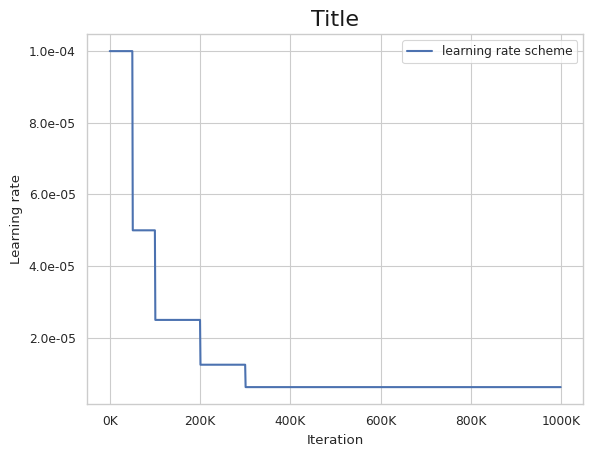

In [ ]:
import tensorflow as tf

def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
    """Multi-steps learning rate scheduler."""
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=lr_steps, values=lr_steps_value)


def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
    """Cosine annealing learning rate scheduler with restart."""
    return tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate=initial_learning_rate,
        first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
        alpha=lr_min / initial_learning_rate)



    # pretrain PSNR lr scheduler
lr_scheduler_D = MultiStepLR(1e-4, [50000, 100000, 200000, 300000], 0.5)

    # ESRGAN lr scheduler
lr_scheduler_G = MultiStepLR(1e-4, [50000, 100000, 200000, 300000], 0.5)

    # Cosine Annealing lr scheduler
    # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 250000, 1e-7)

    ##############################
    # Draw figure
    ##############################
N_iter = 1000000
step_list = list(range(0, N_iter, 1000))
lr_list = []
for i in step_list:
     current_lr = lr_scheduler_G(i).numpy()
     lr_list.append(current_lr)

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
mpl.style.use('default')
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('paper')

plt.figure(1)
plt.subplot(111)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title('Title', fontsize=16, color='k')
plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
legend = plt.legend(loc='upper right', shadow=False)
ax = plt.gca()
labels = ax.get_xticks().tolist()
for k, v in enumerate(labels):
    labels[k] = str(int(v / 1000)) + 'K'
ax.set_xticklabels(labels)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax.set_ylabel('Learning rate')
ax.set_xlabel('Iteration')
fig = plt.gcf()
plt.show()

# Implementation

1. Load dataset.
2. Compile the Student Model.
3. Load the Teacher model.
4. Initialize optimizers.
5. Execute adversarial training step.

In [2]:
n=5000
lr_list = os.listdir("/content/drive/MyDrive/Image datasets/data/lr_images")[:n]
lr_list.sort

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/Image datasets/data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("/content/drive/MyDrive/Image datasets/data/hr_images")[:n]
hr_list.sort

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/Image datasets/data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

Normalize input

In [3]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split into train and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.2, random_state=42)

In [4]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_G,
                                       beta_1=0.9,
                                       beta_2=0.999)
optimizer_G.build

optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_D,
                                       beta_1=0.9,
                                       beta_2=0.999)
optimizer_D.build

NameError: ignored

# Student Structure

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

#generator = create_gen(lr_ip, num_res_block = 16)
generator = create_gen(lr_ip, num_res_block = 8, filters = 64)
#generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer= optimizer_D, metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg((128,128,3))
#print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# Cimpilation Parameters:
# Loss: binary_crossentropy
# Content: feature map obtained by the j-th convolution (after activation)
# before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optimizer_G)
gan_model.summary()

80134624/80134624 [==============================] - 29s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          5290307   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, 32, 32, 256)          2325568   ['model[0][0]']               
                          

#Teacher Structure

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

#generator = create_gen(lr_ip, num_res_block = 16)
generator_t = create_gen(lr_ip, num_res_block = 16, filters=128)
#generator_t.load_weights('/content/drive/MyDrive/Image datasets/data/models/gen7_e_plus6.h5')
#generator.summary()

discriminator_t = create_disc(hr_ip)
discriminator_t.compile(loss="binary_crossentropy", optimizer= optimizer_D, metrics=['accuracy'])
#discriminator.summary()

vgg_t = build_vgg((128,128,3))
#print(vgg.summary())
vgg_t.trainable = False

teacher = create_comb(generator_t, discriminator_t, vgg_t, lr_ip, hr_ip)

# Cimpilation Parameters:
# Loss: binary_crossentropy
# Content: feature map obtained by the j-th convolution (after activation)
# before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
teacher.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optimizer_G)

teacher.summary()


ValueError: ignored

In [ ]:
from keras.models import load_model
from numpy.random import randint

Teacher = load_model('/content/drive/MyDrive/Image datasets/data/models/gen7_e_plus6.h5', compile=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, weight_decay=0.0, amsgrad=False)

Teacher.compile(optimizer=optimizer,
              loss=["binary_crossentropy", "mse"],
              metrics=['accuracy'])

# Combining the Pieces:

Model Training Step Function

In [ ]:
loss_fn = tf.keras.losses.MeanSquaredError(reduction="none")
metric_fn = tf.keras.metrics.Mean()
student_psnr = tf.keras.metrics.Mean()
teacher_psnr = tf.keras.metrics.Mean()

# define vars!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
alpha =  1e-4
lambda_ = 5e-2
teacher_disc = discriminator
generator_metric = tf.keras.metrics.Mean()
discriminator_metric = tf.keras.metrics.Mean()
dummy_optimizer = tf.optimizers.Adam()

ra_generator = RelativisticAverageLoss(
        teacher_disc, type_="G")
ra_discriminator = RelativisticAverageLoss(
        teacher_disc, type_="D")
perceptual_loss = PerceptualLoss(
        weights="imagenet",
        input_shape=(128,128,3),
        loss_type="L2")
#student_psnr = tf.keras.metrics.Mean()
#teacher_psnr = tf.keras.metrics.Mean()

In [ ]:
class AccumulateNorm(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1,center=False, scale=False)

    def call(self, inputs):

        _ = self.bn(inputs)
        return inputs

def get_margin(std, mean):

    margin = []
    for (s, m) in zip(std, mean):
        s = abs(s)

        if norm.cdf(-m / s) > 0.001:
            margin.append(- s * math.exp(-(m / s) ** 2 / 2) / math.sqrt(2 * math.pi) / norm.cdf(-m / s) + m)
        else:
            margin.append(-3 * s)
    return tf.convert_to_tensor(margin, dtype=tf.float32)

def get_connectors():

        connectors = []
        for i in range(len([2,12,16])):

            model = tf.keras.Sequential()
            model.add(tf.keras.Input(shape=(128 // 4,
                                            128 // 4,
                                            64)))
            n = math.sqrt(2.0 / 128)
            model.add(tf.keras.layers.Conv2D(128,
                                             kernel_size=1, strides=1, use_bias=False,
                                             kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=n)))
            model.add(tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001))

            connectors.append(model)

def get_margins():

    batch_norms = [l.get_weights() for l in Teacher.layers if isinstance(l, AccumulateNorm)]
    print(Teacher.layers)
    batch_norms = [batch_norms[i] for i in [2,12,16]]
    means = [bn[0] for bn in batch_norms]
    stds = [tf.math.sqrt(bn[1]) for bn in batch_norms]
    margins = [get_margin(m,s) for (m,s) in zip(means, stds)]


get_connectors()
get_margins()

[<keras.src.engine.input_layer.InputLayer object at 0x7c90ab4e48e0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c90ab4e55d0>, <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7c90b8162260>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c90ab4e7250>, <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7c90b8160820>, <keras.src.layers.merging.add.Add object at 0x7c90b8161390>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c90b81617b0>, <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7c90b8162b30>, <keras.src.layers.merging.add.Add object at 0x7c90b84ac1f0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c90b84ac6a0>, <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7c90b816a650>, <keras.src.layers.merging.add.Add object at 0x7c90b81322f0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c90ab4e7a90>, <keras.src.layers.activation.leaky_relu.LeakyReLU object at 0x7c90b8131ab0>

IndexError: ignored

In [ ]:
alpha =  1e-4
lambda_ = 5e-2
def _vgg(output_layer):
    vgg = tf.keras.applications.vgg19.VGG19(input_shape=(None, None, 3), include_top=False)
    return tf.keras.models.Model(vgg.input, vgg.layers[output_layer].output)


def vgg_22():
    return _vgg(5)


def vgg_54():
    return _vgg(20)

perc_model = vgg_54()

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def content_loss(hr, sr):

        sr = prep(sr)
        hr = prep(hr)
        sr_features = perc_model(sr, training=False) / 12.75
        hr_features = perc_model(hr, training=False) / 12.75

        return out_loss(hr_features, sr_features)


def generator_adversarial_loss(sr_disc):

        return bce (tf.ones_like(sr_disc), sr_disc) # Discriminator must output 1 for SR images


def discriminator_adversarial_loss(hr_disc, sr_disc):

        hr_loss = bce(tf.ones_like(hr_disc), hr_disc) # Discriminator must output 1 for HR images
        sr_loss = bce(tf.zeros_like(sr_disc), sr_disc) # Discriminator must output 0 for SR images
        return hr_loss + sr_loss


def gradient_penalty(hr, sr):

        eps = tf.random.uniform(np.array([sr.shape[0],1,1,1]), 0.0, 1.0, dtype=tf.float32)
        x_hat = eps * hr + (1 - eps) * sr

        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = discriminator(x_hat)

        grads = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(grads**2, axis=[1,2]))
        d_reg = tf.reduce_mean((ddx-1.0)**2)

        return d_reg


def fakd_loss(ft, fs):

        fs_n = tf.linalg.normalize(fs)[0]
        fs_n = fs / tf.repeat(tf.norm(fs, ord='euclidean', axis=-1)[...,None],
                              256,
                              axis=-1)
        fs_r = tf.reshape(fs_n, [len([2,4,8]),
                                 1,
                                 128 // 4 * 128 // 4,
                                 256])
        fs_T = tf.transpose(fs_r, [0,1,3,2])
        a_s = tf.linalg.matmul(fs_r, fs_T)

        ft_n = tf.linalg.normalize(ft)[0]
        ft_r = tf.reshape(ft_n, [len([2, 12, 16]),
                                 1,
                                 128 // 4 * 128 // 4,
                                 256])
        ft_T = tf.transpose(ft_r, [0,1,3,2])
        a_t = tf.linalg.matmul(ft_r, ft_T)

        d = a_t - a_s
        norm = tf.math.reduce_mean(tf.math.abs(d), axis=[1,2,3])
        loss = tf.reduce_sum(norm)
        #norm = tf.math.reduce_sum(tf.math.abs(d), axis=[0,2,3])
        #loss = tf.reduce_mean(norm)

        return loss
out_loss = tf.keras.losses.MeanSquaredError()

kl = tf.keras.losses.KLDivergence()
gen_mean = tf.keras.metrics.Mean()
disc_mean = tf.keras.metrics.Mean()
prep = tf.keras.applications.vgg19.preprocess_input

In [ ]:
from tensorflow._api.v2.compat.v1 import float32
fake_label = np.zeros((1, 1)) # Assign a label of 0 to all fake (generated images)
real_label = np.ones((1, 1)) # Assign a label of 1 to all real images.

g_losses = []
d_losses = []

#for i in range(len(lr_images)):
for i in range(len(lr_train)):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:


      lr = lr_train[i]
      hr = hr_train[i]

      lr = tf.cast(lr, tf.float32)
      hr = tf.cast(hr, tf.float32)
      lr = tf.expand_dims(lr, axis=0)
      hr = tf.expand_dims(hr, axis=0)

      sr, feats_s = gan_model([lr,hr], training=True)

      print(sr.shape)

      hr_disc = discriminator(hr, training=True)
      sr_disc = discriminator(sr, training=True)

      cont_loss = content_loss(hr, sr)
      gen_adv_loss = generator_adversarial_loss(sr_disc)

      print(cont_loss, gen_adv_loss)
      cont_loss = tf.get_static_value(cont_loss)
      gen_adv_loss = tf.get_static_value(gen_adv_loss)

      perc_loss = cont_loss + alpha*(gen_adv_loss)

      disc_adv_loss = discriminator_adversarial_loss(hr_disc, sr_disc)
      disc_reg = gradient_penalty(hr, sr)

      disc_loss = disc_adv_loss + 0.0*disc_reg

      sr_t = Teacher(lr, training = False)
      feats_t = vgg(sr_t)
      out_kd_loss = out_loss(sr_t, sr)

      feats_t = tf.gather(feats_t, [2,12,16])
      feats_s = tf.gather(feats_s, [2,4,8])

      print(feats_t.shape, feats_s.shape)

      feats_t = tf.squeeze(feats_t)
      feats_s = tf.squeeze(feats_s)

      print(feats_t.shape, feats_s.shape)

      feat_kd_loss = fakd_loss(feats_t, feats_s)
      perc_loss += 1 * feat_kd_loss + 0.1 * out_kd_loss

      gen_grads = gen_tape.gradient(perc_loss, gan_model.trainable_variables)
      disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      optimizer_G.apply_gradients(zip(gen_grads, generator.trainable_variables))
      optimizer_D.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

      d_losses.append(disc_loss)
      g_losses.append(perc_loss)

    print("Step: " + int.__str__(i))

    clear_output()

#Convert the list of losses to an array
g_losses = np.array(g_losses)
d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
g_loss = np.sum(g_losses, axis=0) / len(g_losses)
d_loss = np.sum(d_losses, axis=0) / len(d_losses)

generator.save("/content/drive/MyDrive/Image datasets/data/models/Student/gen2.h5")




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from numpy.random import randint
import tensorflow as tf

generator = load_model('/content/drive/MyDrive/Image datasets/data/models/Student/gen2.h5', compile=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, weight_decay=0.0, amsgrad=False)

generator.compile(optimizer=optimizer,
              loss=["binary_crossentropy", "mse"],
              metrics=['accuracy'])

[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()